In [1]:
# Repository setup and reproducibility
from pathlib import Path
import sys

# Ensure repo root on sys.path
try:
    from utils.path_helpers import add_repo_root_to_sys_path
except Exception:
    cur = Path.cwd()
    for parent in [cur] + list(cur.parents):
        if (parent / "requirements.txt").exists() or (parent / ".git").exists():
            sys.path.insert(0, str(parent))
            break
    from utils.path_helpers import add_repo_root_to_sys_path

add_repo_root_to_sys_path()
from utils.device import backend_info, ensure_seed
print("Backend:", backend_info())
ensure_seed(42)

artifacts_dir = Path('artifacts')
artifacts_dir.mkdir(exist_ok=True)
print("Setup complete.")

Backend: Backend=MLX version=0.29.3 device=DeviceType.gpu
Setup complete.


# Project 2: Logistic Regression — from scratch

## Goal
Extend gradient descent to binary classification via sigmoid activation and cross-entropy loss.

## Learning Objectives
- Derive sigmoid function and cross-entropy loss
- Implement logistic regression using gradient descent
- Understand decision boundaries and probability calibration
- Compare to linear regression: why sigmoid is needed for classification
- Visualize decision boundaries in 2D and loss surfaces

## Prerequisites
- Project 1 (Linear Regression): comfortable with gradient descent
- Calculus: partial derivatives; probability basics

## What You'll Build
- NumPy-only logistic regression with visualization of decision boundaries

## Estimated Time
- 3–5 hours

## How to Use This Notebook
1. Run the setup cell to configure environment.
2. Follow top-to-bottom: theory → implementation → experiments → analysis.
3. Figures saved to `artifacts/`.

---

# Project 2: Binary Classification with Logistic Regression

## Goal
Understand classification, cross-entropy loss, and probability outputs.

## Learning Objectives
- Why sigmoid instead of linear for classification?
- What is cross-entropy loss and why use it?
- How does probability output differ from regression?
- What does the decision boundary represent?
- Why is the gradient computation different?

## Theoretical Foundation

### Sigmoid Function
$$\sigma(z) = \frac{1}{1 + e^{-z}}$$

### Logistic Regression Model
$$\hat{y} = \sigma(w^T x + b)$$

### Binary Cross-Entropy Loss
$$L = -\frac{1}{n}\sum_{i=1}^{n}[y_i \log(\hat{y}_i) + (1-y_i)\log(1-\hat{y}_i)]$$

In [2]:
# Setup - Import libraries
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('/Users/mark/git/learning-ml-to-llm')

from utils.data_generators import generate_binary_classification_data
from utils.visualization import plot_loss_curve, plot_decision_boundary
from utils.metrics import binary_cross_entropy, accuracy

print("Libraries imported!")

Libraries imported!


In [3]:
## Step 1: Generate Binary Classification Data

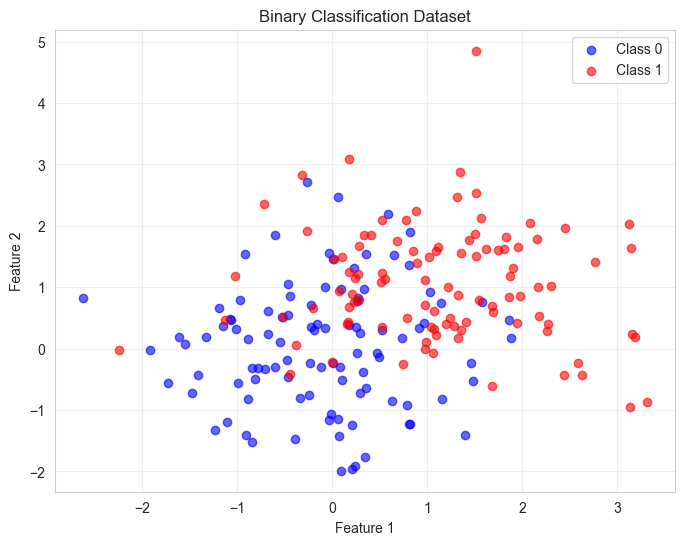

Dataset shape: (200, 2)
Number of class 0 samples: 100
Number of class 1 samples: 100


In [4]:
# Generate binary classification data
X, y = generate_binary_classification_data(n_samples=200, n_features=2, random_state=42)

# Visualize the data
plt.figure(figsize=(8, 6))
plt.scatter(X[y == 0, 0], X[y == 0, 1], c='blue', label='Class 0', alpha=0.6)
plt.scatter(X[y == 1, 0], X[y == 1, 1], c='red', label='Class 1', alpha=0.6)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Binary Classification Dataset')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Dataset shape: {X.shape}")
print(f"Number of class 0 samples: {np.sum(y == 0)}")
print(f"Number of class 1 samples: {np.sum(y == 1)}")

## Step 2: Implement Sigmoid Function

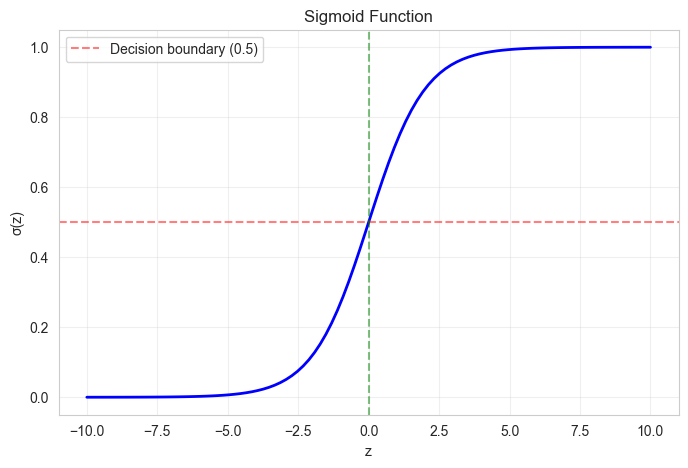

Sigmoid function implemented and visualized!


In [5]:
def sigmoid(z):
    """
    Compute the sigmoid function.
    
    Parameters:
    -----------
    z : numpy array
        Input values
        
    Returns:
    --------
    numpy array
        Sigmoid of input values
    """
    return 1 / (1 + np.exp(-z))

# Test the sigmoid function
z_test = np.linspace(-10, 10, 100)
sigmoid_test = sigmoid(z_test)

plt.figure(figsize=(8, 5))
plt.plot(z_test, sigmoid_test, 'b-', linewidth=2)
plt.axhline(y=0.5, color='r', linestyle='--', alpha=0.5, label='Decision boundary (0.5)')
plt.axvline(x=0, color='g', linestyle='--', alpha=0.5)
plt.xlabel('z')
plt.ylabel('σ(z)')
plt.title('Sigmoid Function')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

print("Sigmoid function implemented and visualized!")

## Step 3: Implement LogisticRegression Class

In [6]:
class LogisticRegression:
    """
    Logistic Regression classifier implemented from scratch.
    """
    
    def __init__(self, learning_rate=0.01, n_iterations=1000):
        """
        Initialize the logistic regression model.
        
        Parameters:
        -----------
        learning_rate : float
            Step size for gradient descent
        n_iterations : int
            Number of training iterations
        """
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.weights = None
        self.bias = None
        self.losses = []
        
    def fit(self, X, y):
        """
        Train the logistic regression model using gradient descent.
        
        Parameters:
        -----------
        X : numpy array of shape (n_samples, n_features)
            Training data
        y : numpy array of shape (n_samples,)
            Target values (0 or 1)
        """
        n_samples, n_features = X.shape
        
        # Initialize weights and bias
        self.weights = np.zeros(n_features)
        self.bias = 0
        
        # Gradient descent
        for i in range(self.n_iterations):
            # Forward pass: compute predictions
            linear_pred = np.dot(X, self.weights) + self.bias
            predictions = sigmoid(linear_pred)
            
            # Compute loss
            loss = binary_cross_entropy(y, predictions)
            self.losses.append(loss)
            
            # Compute gradients
            dw = (1 / n_samples) * np.dot(X.T, (predictions - y))
            db = (1 / n_samples) * np.sum(predictions - y)
            
            # Update parameters
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db
            
            # Print progress every 100 iterations
            if (i + 1) % 100 == 0:
                print(f"Iteration {i + 1}/{self.n_iterations}, Loss: {loss:.4f}")
    
    def predict_proba(self, X):
        """
        Predict probability estimates.
        
        Parameters:
        -----------
        X : numpy array of shape (n_samples, n_features)
            Input data
            
        Returns:
        --------
        numpy array of shape (n_samples,)
            Predicted probabilities
        """
        linear_pred = np.dot(X, self.weights) + self.bias
        return sigmoid(linear_pred)
    
    def predict(self, X, threshold=0.5):
        """
        Predict class labels.
        
        Parameters:
        -----------
        X : numpy array of shape (n_samples, n_features)
            Input data
        threshold : float
            Decision threshold
            
        Returns:
        --------
        numpy array of shape (n_samples,)
            Predicted class labels (0 or 1)
        """
        probabilities = self.predict_proba(X)
        return (probabilities >= threshold).astype(int)

print("LogisticRegression class implemented!")

LogisticRegression class implemented!


## Step 4: Train and Visualize Decision Boundary

Iteration 100/1000, Loss: 0.4551
Iteration 200/1000, Loss: 0.4368
Iteration 300/1000, Loss: 0.4324
Iteration 400/1000, Loss: 0.4310
Iteration 500/1000, Loss: 0.4306
Iteration 600/1000, Loss: 0.4304
Iteration 700/1000, Loss: 0.4303
Iteration 800/1000, Loss: 0.4303
Iteration 900/1000, Loss: 0.4303
Iteration 1000/1000, Loss: 0.4303

Training Accuracy: 0.8150


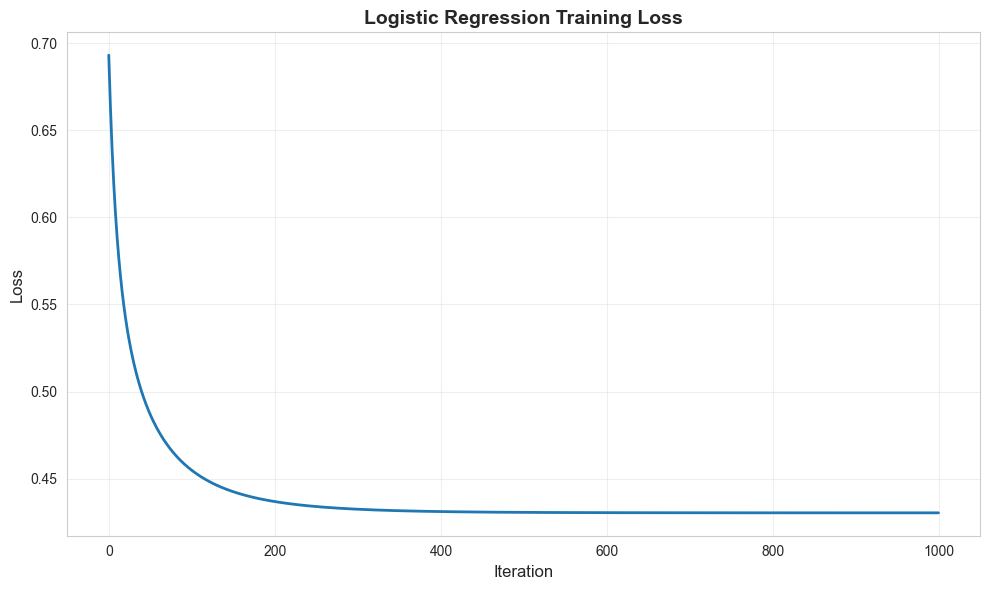

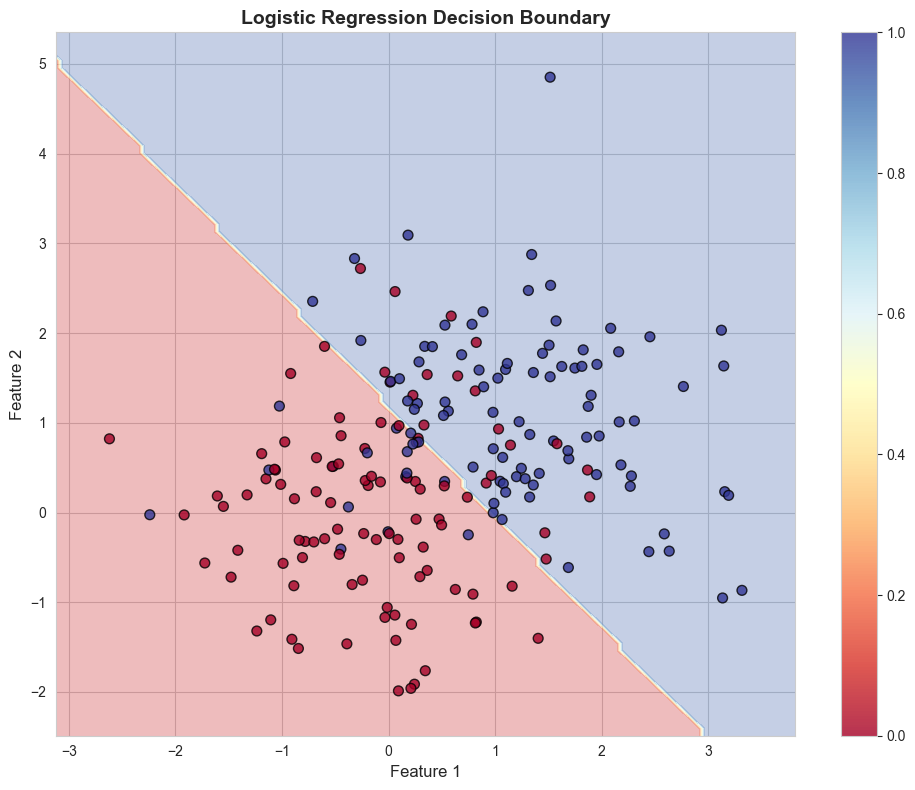

In [7]:
# Train the model
model = LogisticRegression(learning_rate=0.1, n_iterations=1000)
model.fit(X, y)

# Make predictions
y_pred = model.predict(X)
y_proba = model.predict_proba(X)

# Calculate accuracy
acc = accuracy(y, y_pred)
print(f"\nTraining Accuracy: {acc:.4f}")

# Visualize the loss curve
plot_loss_curve(model.losses, title="Logistic Regression Training Loss")

# Visualize the decision boundary
plot_decision_boundary(X, y, model, title="Logistic Regression Decision Boundary")

## Step 5: Experiment with Different Parameters

Iteration 100/1000, Loss: 0.6780
Iteration 200/1000, Loss: 0.6643
Iteration 300/1000, Loss: 0.6518
Iteration 400/1000, Loss: 0.6404
Iteration 500/1000, Loss: 0.6301
Iteration 600/1000, Loss: 0.6207
Iteration 700/1000, Loss: 0.6121
Iteration 800/1000, Loss: 0.6043
Iteration 900/1000, Loss: 0.5970
Iteration 1000/1000, Loss: 0.5903
Iteration 100/1000, Loss: 0.5908
Iteration 200/1000, Loss: 0.5441
Iteration 300/1000, Loss: 0.5175
Iteration 400/1000, Loss: 0.5000
Iteration 500/1000, Loss: 0.4873
Iteration 600/1000, Loss: 0.4776
Iteration 700/1000, Loss: 0.4701
Iteration 800/1000, Loss: 0.4640
Iteration 900/1000, Loss: 0.4590
Iteration 1000/1000, Loss: 0.4550
Iteration 100/1000, Loss: 0.4551
Iteration 200/1000, Loss: 0.4368
Iteration 300/1000, Loss: 0.4324
Iteration 400/1000, Loss: 0.4310
Iteration 500/1000, Loss: 0.4306
Iteration 600/1000, Loss: 0.4304
Iteration 700/1000, Loss: 0.4303
Iteration 800/1000, Loss: 0.4303
Iteration 900/1000, Loss: 0.4303
Iteration 1000/1000, Loss: 0.4303
Iterati

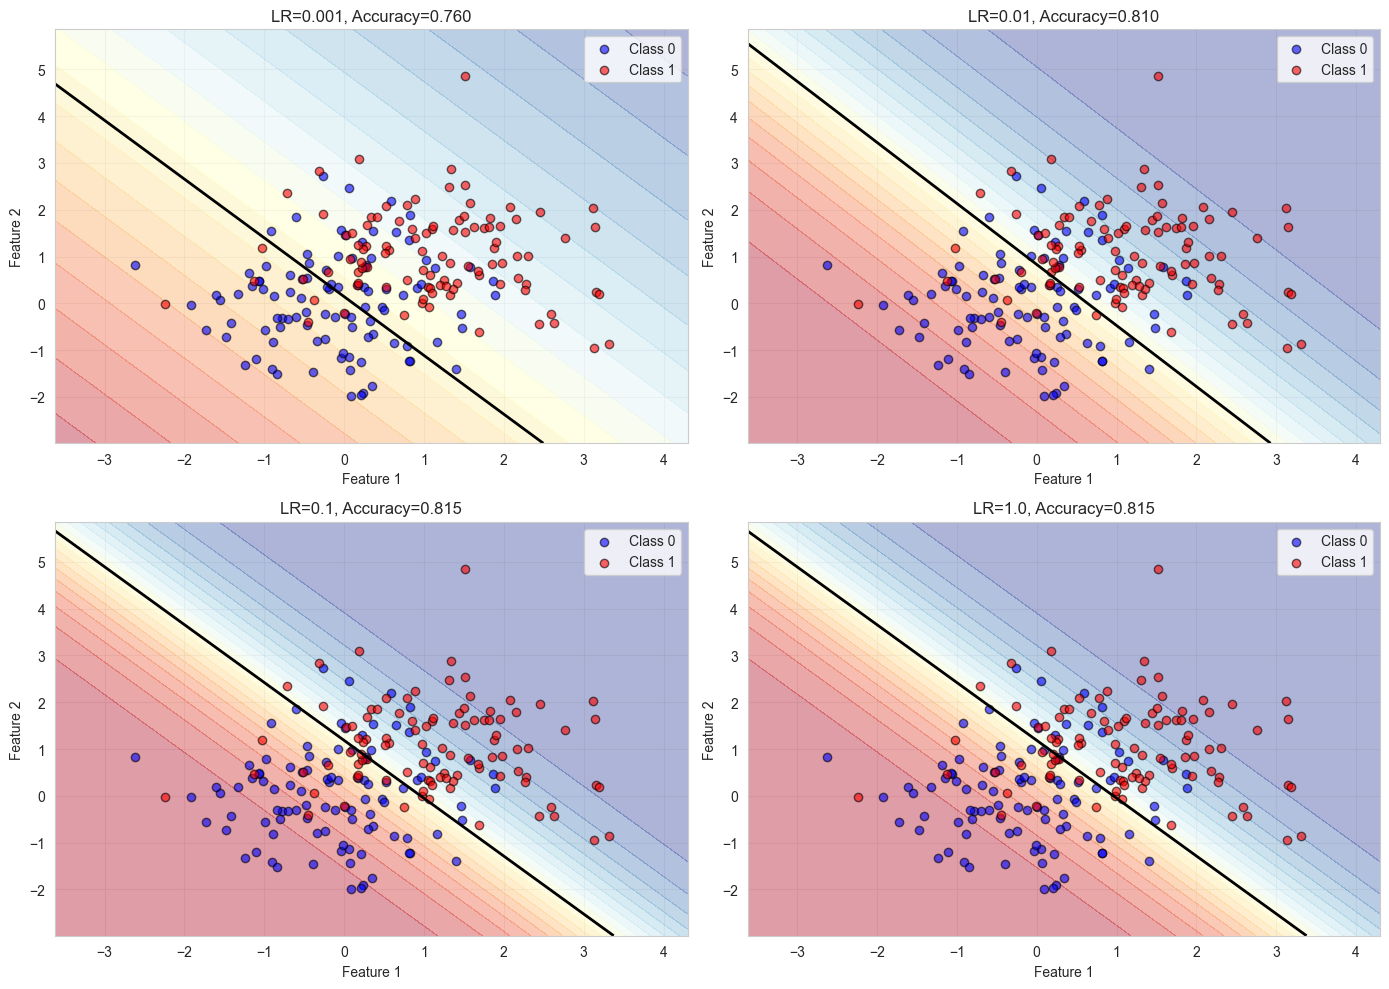

Experiment complete!


In [8]:
# Experiment with different learning rates
learning_rates = [0.001, 0.01, 0.1, 1.0]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

for idx, lr in enumerate(learning_rates):
    # Train model with different learning rate
    model_exp = LogisticRegression(learning_rate=lr, n_iterations=1000)
    model_exp.fit(X, y)
    
    # Make predictions
    y_pred_exp = model_exp.predict(X)
    acc_exp = accuracy(y, y_pred_exp)
    
    # Plot decision boundary
    ax = axes[idx]
    
    # Create mesh
    h = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    # Predict on mesh
    Z = model_exp.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot contours and data points
    ax.contourf(xx, yy, Z, alpha=0.4, cmap='RdYlBu', levels=20)
    ax.contour(xx, yy, Z, levels=[0.5], colors='black', linewidths=2)
    ax.scatter(X[y == 0, 0], X[y == 0, 1], c='blue', label='Class 0', alpha=0.6, edgecolors='k')
    ax.scatter(X[y == 1, 0], X[y == 1, 1], c='red', label='Class 1', alpha=0.6, edgecolors='k')
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_title(f'LR={lr}, Accuracy={acc_exp:.3f}')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Experiment complete!")

## Exercises & Extensions

**Warm-up**:
1. Plot sigmoid function: how does it map (-inf, +inf) to (0, 1)?
2. Compute cross-entropy loss for a few predictions. Compare to MSE.
3. Add L2 regularization. How does it change decision boundary?

**Intermediate**:
4. Implement probability calibration curves: are predicted probabilities reliable?
5. Try different learning rates. Which achieves best accuracy on held-out test set?
6. Feature-scale vs raw: impact on convergence speed.

**Advanced**:
7. Implement mini-batch gradient descent (batch size = 32). Compare to full-batch.
8. Use ROC curve to find optimal decision threshold (not 0.5).
9. Compare your logistic regression to scikit-learn. Plot confusion matrices side-by-side.

---

## Summary & Bridge Forward

**What you learned**:
- Classification requires a different loss (cross-entropy, not MSE).
- Sigmoid squashes linear output to probability [0, 1].
- Gradient descent applies equally: just a different loss function.
- Decision boundaries emerge from learned weights.
- Probability calibration matters for real applications.

**Why this matters**:
- Logistic regression is the simplest classifier; all neural networks build on this.
- Cross-entropy loss dominates modern deep learning (not MSE).
- Understanding linear decision boundaries prepares you for nonlinear ones (Project 11.5 neural networks).

**Next project** (Multiclass):
- Generalize sigmoid to softmax (multiclass probability).
- Extend binary cross-entropy to categorical cross-entropy.

**Your takeaway**: Classification is regression + sigmoid + cross-entropy. Same optimization loop; different output.